In [1]:
import theano.tensor as T
import numpy as np
import theano
from lasagne import layers as L
import matplotlib.pyplot as plt
%matplotlib inline

Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 660 Ti (0000:01:00.0)


In [2]:

# X,m,c,w,c0,w0 = T.matrix(),T.tensor3(),T.matrix(),T.matrix(),T.vector(),T.vector()
# iu  =iterative_update(m,c,w,X,c0,w0)
# f = theano.function([X,m,c,w,c0,w0],iu,allow_input_downcast=True)

# def gen_mixture(ns,dim,sigm=.3):
#     ns = np.array(ns)
#     means = []
#     covs = []
#     weights = ns.astype(np.float32)/ns.sum()
#     res = np.zeros((int(sum(ns)),dim),dtype=np.float32)
#     i = 0
#     for n in ns:
#         covs.append(sigm*(np.random.rand(dim)+1.))
#         means.append(10*(np.random.rand(dim)))
#         res[i:i+n] = np.random.randn(n,dim)*covs[-1][None,:]+means[-1][None,:]
#         covs[-1] = np.std(res[i:i+n],0)**2
#         means[-1] = np.mean(res[i:i+n],0)
#         i=i+n
#     return res,np.array(means),np.array(covs),weights

# X,tm,tc,tw = gen_mixture([200,300,200,100],2,0.3)
# np.random.shuffle(X)
# m = X[:4].reshape((1,4,-1))
# c = np.ones((1,4))*0.1
# w = np.ones((1,4))*0.25
# for i in range(4,len(X)):
#     m,c,w = f(X[i].reshape((1,-1)),m,c,w,np.array([0.01]),np.array([0.1]))
    
# plt.plot(X[:,0],X[:,1],'o')
# plt.plot(tm[:,0],tm[:,1],'o')
# #plt.plot(X[:20,0],X[:20,1],'o')
# plt.plot(m[0,:,0],m[0,:,1],'o')

In [3]:
import lasagne
from Layers import MyRecurrentLayer,ConstantLayer,InitHiddenLayer,UpdateGMMLayer,ScoreGMMLayer


In [4]:
from broadcast import BroadcastLayer,UnbroadcastLayer
from utils import get_network_str
from utils import load_weights,save_weights,Logger
from easydict import EasyDict
cfg = EasyDict()
cfg.SEQ_LENGTH = 36
cfg.TILE_SIZE = 31
cfg.gm_num = 4
cfg.ndim = 3
cfg.NAME_PREFIX = 'rec'
cfg.NETWORK = 'conv4_net_dense'
cfg.NAME='experiments/'+cfg.NAME_PREFIX+cfg.NETWORK+'%d'%(cfg.ndim)

cfg.TRAIN = EasyDict()
cfg.TRAIN.BATCH_SIZE = 4
cfg.TRAIN.EPOCH = 0
cfg.TRAIN.EPOCH_NUM = 20

cfg.DATASET = EasyDict()
cfg.DATASET.TRAIN_MINR = .1
cfg.DATASET.TRAIN_MAXR = 1.
cfg.DATASET.T_SIZE = 64
cfg.DATASET.CASHE_SAMPLES = True

cfg.logger = Logger('std')

In [5]:
from loader import PatchLoader
train_loader = PatchLoader('data/train_%d'%cfg.DATASET.T_SIZE,
                           cfg.DATASET.T_SIZE,
                           cfg.SEQ_LENGTH,
                           cfg.DATASET.TRAIN_MINR,
                           cfg.DATASET.TRAIN_MAXR,
                           cfg.TILE_SIZE,
                           cfg.DATASET.CASHE_SAMPLES)
test_loader = PatchLoader('data/test_%d'%cfg.DATASET.T_SIZE,
                           cfg.DATASET.T_SIZE,
                           cfg.SEQ_LENGTH,
                           cfg.DATASET.TRAIN_MINR,
                           cfg.DATASET.TRAIN_MAXR,
                           cfg.TILE_SIZE,
                           cfg.DATASET.CASHE_SAMPLES)

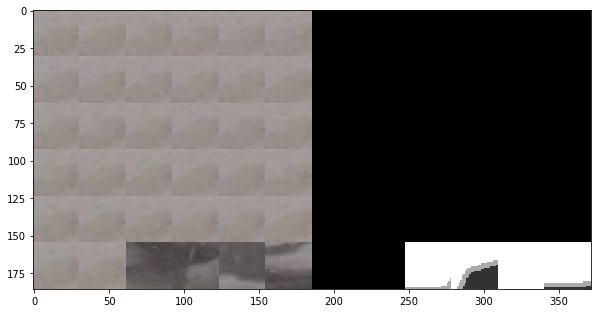

In [6]:
from dataset_tools import draw
im,mask,_,_ = train_loader.load_sample(5,0)
draw(im,mask)

In [7]:
from loader import data_generator as generate_sample
def data_generator(gmm_loader,
                   batch_size,
                   epoch_size,
                   gm_num,
                   shuffle=False):
    X,y = [],[]
    for patch,mask in generate_sample(gmm_loader,epoch_size*batch_size,shuffle):
        X.append(patch)
        y.append(mask[gm_num:])
        if(len(X) >= batch_size):
            yield np.array(X),np.array(y)
            X,y = [],[]
            break        

In [17]:
def build_cw_net(data):
    #c = L.Conv2DLayer(data,1,3,nonlinearity=lasagne.nonlinearities.softplus,name='cov',pad='same')
    #w = L.Conv2DLayer(data,1,3,nonlinearity=lasagne.nonlinearities.sigmoid,name='weight',pad='same')
    one = L.SliceLayer(data,slice(None,1),1)
    c = ConstantLayer(one,0.03,trainable=True,name='constants_c')
    c = L.NonlinearityLayer(c,lasagne.nonlinearities.softplus,name='softplus_c')
    w = ConstantLayer(one,-10.,trainable=True,name='constant_w')
    w = L.NonlinearityLayer(w,lasagne.nonlinearities.sigmoid,name='sigmoid_w')
    return c,w
    
def build_input_to_hidden(gm_num,input_shape,features_tensor=None,hidden_tensor=None):
    features = L.InputLayer(input_shape,features_tensor,name='features')
    hidden = L.InputLayer((features.output_shape[0],gm_num,features.output_shape[1]+2)+features.output_shape[-2:],
                          hidden_tensor,name='hidden')
    bcast_hidden = BroadcastLayer(hidden,(0,3,4),name='bcast_hidden')
    bcast_features = BroadcastLayer(features,(0,2,3),name='bcast_features')
    bcast_features_reshaped = L.reshape(bcast_features,([0],1,[1]),name='bcast_features_reshaped')
    score = ScoreGMMLayer(bcast_features_reshaped,bcast_hidden,name='score_gmm')
    scored_features = L.ConcatLayer([bcast_features,score],1,name='scored_features')
    scored_features = UnbroadcastLayer(scored_features,bcast_features,name='ubcast_features')
    cov,weight = build_cw_net(scored_features)
    featurescw = L.ConcatLayer([features,cov,weight],1,name='featurescw')
    bcast_featurescw = BroadcastLayer(featurescw,(0,2,3),name='bcast_featurescw')
    update_gmm = UpdateGMMLayer(bcast_featurescw,bcast_hidden,name='update_gmm')
    hidden = UnbroadcastLayer(update_gmm,bcast_hidden,name='unbcast_hidden')
    return hidden

def build_feature_net(data,output_channels,input_shape):
    assert(output_channels == 3)
    res = L.InputLayer(input_shape,data/256.,name='input')
    return res
#     bcast = res = BroadcastLayer(res,(0,1),res,name='bcast_input')
#     for i,filters in enumerate([12,24,output_channels]):
#         res = L.Conv2DLayer(res,filters,3,nonlinearity=None,name="conv%d"%i,pad='same')
#         res = L.BatchNormLayer(res,name="bn%d"%i)
#         res = L.NonlinearityLayer(res,lasagne.nonlinearities.rectify,name='relu%d'%i)
#     return UnbroadcastLayer(res,bcast,name='unbcast_features')
    
def build_net(data,gm_num,ndim,input_shape,logger=Logger('std')):
    features = build_feature_net(data,ndim,input_shape)
    logger.log('feature network')
    logger.log(get_network_str(features))
    init_features = L.SliceLayer(features,slice(0,gm_num),1,name='init_features')
    init_layer = InitHiddenLayer(init_features,name='init_hidden')
    features = L.SliceLayer(features,slice(gm_num,None),1,name='features')
    input_to_hiden = build_input_to_hidden(gm_num,input_shape[:1]+(ndim,)+input_shape[3:])
    logger.log('input_to_hidden network')
    logger.log(get_network_str(input_to_hiden))
    mcw = MyRecurrentLayer(features,input_to_hiden,
                           hid_init=init_layer,
                           name='recurrent_mcw',
                           grad_clipping=0.5)
    bcast_features = BroadcastLayer(features,(0,1,3,4),name='bcast_features')
    bcast_features_reshaped  = L.reshape(bcast_features,([0],1,[1]),name='bcast_features_reshaped')
    bcast_mcw = BroadcastLayer(mcw,(0,1,4,5),name='bcast_mcw')
    score = ScoreGMMLayer(bcast_features_reshaped,bcast_mcw,name='score_gmm')
    scored_features = L.ConcatLayer([bcast_features,score],name='scored_features')
    unbcast_scored_features = UnbroadcastLayer(scored_features,bcast_features,name='unbcast_scored_features')
    bcast_features = BroadcastLayer(unbcast_scored_features,(0,1),name='bcast_features')
    bcast_out = L.SliceLayer(bcast_features,slice(-1,None),1,name='get_score')
    bcast_out = L.Conv2DLayer(bcast_out,1,1,nonlinearity=lasagne.nonlinearities.sigmoid,name="bcast_out",pad='same')
    out = UnbroadcastLayer(bcast_out,bcast_features,name='out')    
    return out,mcw

In [18]:
def make_fn(data,label,net,non_learn_params,gm_num,train=True):
    predict = L.get_output(net, deterministic= (not train))
    flat_label = label.flatten()
    mask = (T.abs_(flat_label-0.5) > 0.1).nonzero()
    flat_label = flat_label[mask]
    flat_predict = predict.flatten()[mask]
    loss = -T.mean(lasagne.objectives.binary_crossentropy(flat_predict,flat_label))+\
            lasagne.regularization.regularize_network_params(net,lasagne.regularization.l2)*1e-2+\
            lasagne.regularization.regularize_network_params(net,lasagne.regularization.l1)*1e-2
    acc = T.mean(lasagne.objectives.binary_accuracy(flat_predict,flat_label))
    
    if(train):
        params = L.get_all_params(net,trainable=True)
        grads = T.grad(loss,params)
        grads = lasagne.updates.total_norm_constraint(grads,non_learn_params['total_grad_constraint'])
        updates = lasagne.updates.momentum(grads,params,
                                           learning_rate=non_learn_params['lr'],
                                           momentum=non_learn_params['momentum'])
    else:
        updates = None
    return theano.function([data, label], [predict,loss,acc],\
                               allow_input_downcast=True, updates=updates)


    
data = T.tensor5()
label = T.tensor4()
net,mcw = build_net(data,cfg.gm_num,cfg.ndim,
                input_shape=(cfg.TRAIN.BATCH_SIZE,cfg.SEQ_LENGTH,3,cfg.TILE_SIZE,cfg.TILE_SIZE),
                logger=cfg.logger)
cfg.logger.log(get_network_str(net))

non_learn_params={'momentum':theano.shared(np.float32(0.9),allow_downcast=True),
                  'lr' : theano.shared(np.float32(0.1),allow_downcast=True),
                  'total_grad_constraint' : 1.}

train_fn = make_fn(data,label,net,non_learn_params,cfg.gm_num,train=True)
cfg.logger.log('train_fn compiled')
test_fn = make_fn(data,label,net,non_learn_params,cfg.gm_num,train=False)
cfg.logger.log('test_fn compiled')

feature network

Layer    Description            
-----    -----------            
0        input(4, 36, 3, 31, 31)
input_to_hidden network

Layer    Description                        
-----    -----------                        
0        features(4, 3, 31, 31)             
1        bcast_features(3844, 3)            
2        bcast_features_reshaped(3844, 1, 3)
3        hidden(4, 4, 5, 31, 31)            
4        bcast_hidden(3844, 4, 5)           
5        score_gmm(3844, 1)                 
6        scored_features(3844, 4)           
7        ubcast_features(4, 4, 31, 31)      
8        None(4, 1, 31, 31)                 
9        constants_c(4, 1, 31, 31)          
10       softplus_c(4, 1, 31, 31)           
11       constant_w(4, 1, 31, 31)           
12       sigmoid_w(4, 1, 31, 31)            
13       featurescw(4, 5, 31, 31)           
14       bcast_featurescw(3844, 5)          
15       update_gmm(3844, 4, 5)             
16       unbcast_hidden(4, 4, 5, 31, 31)    

Lay

In [19]:
predict_fn = theano.function([data],[L.get_output(net,deterministic=True),L.get_output(mcw,deterministic=True)])
cfg.logger.log('predict_fn compiled')

predict_fn compiled


(4, 32, 1, 31, 31) (4, 36, 3, 31, 31) (4, 32, 4, 5, 31, 31)
1.0


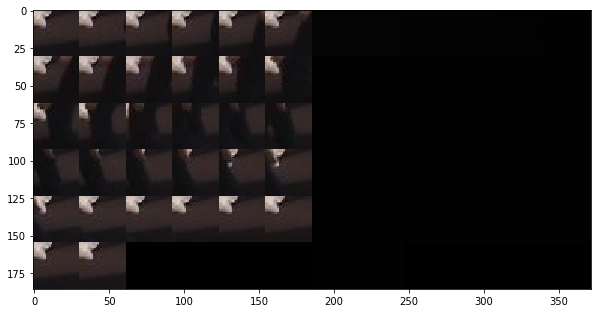

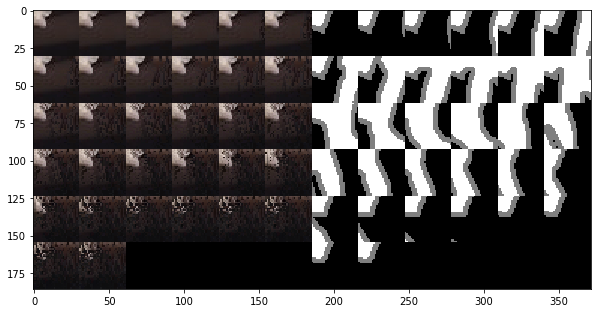

In [27]:
for x,mask in data_generator(train_loader,cfg.TRAIN.BATCH_SIZE,epoch_size=10000000,gm_num=cfg.gm_num,shuffle=True):
    res,mcw = predict_fn(x)
    print res.shape,x.shape,mcw.shape
    x = np.transpose(x[0,cfg.gm_num:],(0,2,3,1)).astype(np.uint8)
    y = (res[0,:,0]*255).astype(np.uint8)
    mask = (mask[0,:]*255).astype(np.uint8)
    m = mcw[0,:,:,:3,:,:]
    w = mcw[0,:,:,4,:,:]
    w = np.where((w/w.min(1)[:,None,:,:]) < 1+1e-10,1.,0.)
    w = w/np.sum(w,1)[:,None,...]
    print w.max()
    m = np.sum(m*w[:,:,None,:,:],1)
    m = (np.transpose(m,(0,2,3,1))*255).astype(np.uint8)
    draw(x,y)
    draw(m,mask)
    
    

In [19]:
from sklearn import metrics
def iterate_batches(fn,data_generator,prefix,metrix = dict(),logger=Logger('std')):
    metrix_res = dict([(k,[]) for k in metrix.keys()])
    for i,batch in enumerate(data_generator()):
        res = fn(*batch)
        label = batch[1].flatten()
        mask = (label>0.9) | (label<0.1)
        for k,m in metrix.items():
            metrix_res[k].append(m(res,label,mask))
    
    s = ' '.join(['%s=%.3f'%(k,np.array(metrix_res[k]).mean()) for k in metrix.keys() ])
    logger.log('%s batch %i %s\n'%(prefix,i,s))
    
lr_schedule = [10,15,18]
metrix = {'loss' : lambda res,label,mask : res[1],
          'acc' : lambda res,label,mask : res[2],
          'aps' : lambda res,label,mask : metrics.average_precision_score(label.flatten()[mask],
                                                                          res[0].flatten()[mask])}
for j in range(cfg.TRAIN.EPOCH,cfg.TRAIN.EPOCH_NUM):
    if(j in lr_schedule):
        lr = non_learn_params['lr']
        lr.set_value(lr.get_value()*0.1)
    iterate_batches(train_fn,\
                    lambda : data_generator(train_loader,cfg.TRAIN.BATCH_SIZE,
                                            epoch_size=10000000,
                                            gm_num=cfg.gm_num,
                                            shuffle=True),
                    'train epoch %d'%j,metrix,logger = cfg.logger)
    #save_weights(net,'%s/models/%03d'%(cfg.NAME,j))
    iterate_batches(test_fn,\
                    lambda : data_generator(test_loader,cfg.TRAIN.BATCH_SIZE,
                                            epoch_size=10000000,
                                            gm_num=cfg.gm_num,
                                            shuffle=False),
                    'test epoch %d'%j,metrix,logger = cfg.logger)
cfg.logger.log('################### done #######################\n')

train epoch 0 batch 0 acc=0.833 loss=-0.558 aps=0.090

test epoch 0 batch 0 acc=0.892 loss=-0.387 aps=0.056

train epoch 1 batch 0 acc=0.916 loss=-0.299 aps=0.044

test epoch 1 batch 0 acc=0.893 loss=-0.401 aps=0.055

train epoch 2 batch 0 acc=0.894 loss=-0.401 aps=0.055

test epoch 2 batch 0 acc=0.904 loss=-0.370 aps=0.068

train epoch 3 batch 0 acc=0.901 loss=-0.382 aps=0.051

test epoch 3 batch 0 acc=0.777 loss=-0.986 aps=0.126



KeyboardInterrupt: 

In [20]:
params = L.get_all_param_values(net,trainable=True)

In [21]:
print params

[array([0.09629874], dtype=float32), array([0.02043735], dtype=float32), array([-0.9729359], dtype=float32), array([[[[1.1502296]]]], dtype=float32), array([-0.08069882], dtype=float32)]
